In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('planes.csv')
df.head()

,flight_id,flight_duration_minutes,actual_departure,actual_arrival,model,fare_conditions,total_seats,count,sum,city_of_departure,city_of_arrival
0,136119,101.0,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,Boeing 737-300,Business,12,11,402600.0,Anapa,Moscow
1,136119,101.0,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,Boeing 737-300,Economy,118,102,1250400.0,Anapa,Moscow
2,136120,99.0,2017-02-24T10:07:00Z,2017-02-24T11:46:00Z,Boeing 737-300,Business,12,11,402600.0,Anapa,Moscow
3,136120,99.0,2017-02-24T10:07:00Z,2017-02-24T11:46:00Z,Boeing 737-300,Economy,118,98,1202800.0,Anapa,Moscow
4,136122,100.0,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,Boeing 737-300,Business,12,10,366000.0,Anapa,Moscow


Загрузка библиотек, загрузка CSV из Метабейз

In [95]:
prices = pd.read_excel('fuel of planes.xlsx')

In [96]:
df = df.merge(prices, on = 'model', how = 'left')

In [97]:
df.head()

,flight_id,flight_duration_minutes,actual_departure,actual_arrival,model,fare_conditions,total_seats,count,sum,city_of_departure,city_of_arrival,tonne per hour,Price RUB/ Tonne,"Rashod, Tonne per minute"
0,136119,101.0,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,Boeing 737-300,Business,12,11,402600.0,Anapa,Moscow,2.4,45000,0.04
1,136119,101.0,2017-01-03T10:08:00Z,2017-01-03T11:49:00Z,Boeing 737-300,Economy,118,102,1250400.0,Anapa,Moscow,2.4,45000,0.04
2,136120,99.0,2017-02-24T10:07:00Z,2017-02-24T11:46:00Z,Boeing 737-300,Business,12,11,402600.0,Anapa,Moscow,2.4,45000,0.04
3,136120,99.0,2017-02-24T10:07:00Z,2017-02-24T11:46:00Z,Boeing 737-300,Economy,118,98,1202800.0,Anapa,Moscow,2.4,45000,0.04
4,136122,100.0,2017-01-08T10:08:00Z,2017-01-08T11:48:00Z,Boeing 737-300,Business,12,10,366000.0,Anapa,Moscow,2.4,45000,0.04


Добавляем расход топлива и его цену для расчета себестоимости рейсов

In [98]:
df.columns

Index(['flight_id', 'flight_duration_minutes', 'actual_departure',
       'actual_arrival', 'model', 'fare_conditions', 'total_seats', 'count',
       'sum', 'city_of_departure', 'city_of_arrival', 'tonne per hour',
       'Price RUB/ Tonne', 'Rashod, Tonne per minute'],
      dtype='object')

In [99]:
df.rename(columns={'count': 'real_seats'}, inplace=True)
df.rename(columns={'sum': 'real_revenue'}, inplace=True)

Переименовываем столбцы для удобства

In [100]:
df['Price_per_place']=df.real_revenue/df.real_seats

In [101]:
df['cost_of_fly']=df['Rashod, Tonne per minute']*df.flight_duration_minutes*df['Price RUB/ Tonne']/2

In [102]:
df['fullfilment'] = df.real_seats/df.total_seats

In [103]:
pvt = pd.pivot_table(df, index = ['flight_id'], values = ['real_revenue','cost_of_fly','total_seats', 'real_seats'],aggfunc=np.sum)

In [104]:
pvt

,cost_of_fly,real_revenue,real_seats,total_seats
flight_id,,,,
136119,181800.0,1653000.0,113,130
136120,178200.0,1605400.0,109,130
136122,180000.0,1431000.0,97,130
136130,178200.0,1556600.0,107,130
136131,178200.0,1812800.0,124,130
...,...,...,...,...
136936,63750.0,632400.0,82,97
136937,63750.0,626100.0,81,97
136951,62475.0,720600.0,90,97


Делаем сводную, изабвляясь от разбивки мест на бизнес-класс и эконом (они оказались бесполезными)

In [105]:
df = df.drop_duplicates(subset=['flight_id'])

In [106]:
pvt = pvt.merge(df, on ='flight_id', how = 'left')

In [107]:
pvt = pvt.drop(columns=['fare_conditions', 'total_seats_y','real_seats_y','real_revenue_y','Price_per_place','cost_of_fly_y','fullfilment'])

In [108]:
pvt['profit'] = pvt.real_revenue_x - pvt.cost_of_fly_x

In [147]:
pvt['fulfillment'] = pvt.real_seats_x/pvt.total_seats_x

In [151]:
pvt.actual_arrival = pd.to_datetime(pvt['actual_arrival'].str.strip(), format='%Y-%m-%dT%H:%M:%SZ')

In [154]:
pvt['number_day_of_week']= pvt.actual_departure.dt.dayofweek

In [161]:
pvt['weekend'] = pvt['number_day_of_week'].apply(lambda x: 'Weekend' if x >= 5  else 'Working day')

In [165]:
pvt['month'] = pvt['actual_departure'].dt.month

In [169]:
pvt['day'] = pvt['actual_departure'].dt.day

Добавляем колонку с прибылью, обрабатываем даты

In [174]:
pvt

,flight_id,cost_of_fly_x,real_revenue_x,real_seats_x,total_seats_x,flight_duration_minutes,actual_departure,actual_arrival,model,city_of_departure,city_of_arrival,tonne per hour,Price RUB/ Tonne,"Rashod, Tonne per minute",profit,fulfillment,number_day_of_week,weekend,month,day
0,136119,181800.0,1653000.0,113,130,101.0,2017-01-03 10:08:00,2017-01-03 11:49:00,Boeing 737-300,Anapa,Moscow,2.4,45000,0.040000,1471200.0,0.869231,1,Working day,1,3
1,136120,178200.0,1605400.0,109,130,99.0,2017-02-24 10:07:00,2017-02-24 11:46:00,Boeing 737-300,Anapa,Moscow,2.4,45000,0.040000,1427200.0,0.838462,4,Working day,2,24
2,136122,180000.0,1431000.0,97,130,100.0,2017-01-08 10:08:00,2017-01-08 11:48:00,Boeing 737-300,Anapa,Moscow,2.4,45000,0.040000,1251000.0,0.746154,6,Weekend,1,8
3,136130,178200.0,1556600.0,107,130,99.0,2017-02-13 10:07:00,2017-02-13 11:46:00,Boeing 737-300,Anapa,Moscow,2.4,45000,0.040000,1378400.0,0.823077,0,Working day,2,13
4,136131,178200.0,1812800.0,124,130,99.0,2017-01-28 10:07:00,2017-01-28 11:46:00,Boeing 737-300,Anapa,Moscow,2.4,45000,0.040000,1634600.0,0.953846,5,Weekend,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,136936,63750.0,632400.0,82,97,50.0,2017-01-02 09:28:00,2017-01-02 10:18:00,Sukhoi Superjet-100,Anapa,Belgorod,1.7,45000,0.028333,568650.0,0.845361,0,Working day,1,2
123,136937,63750.0,626100.0,81,97,50.0,2017-01-03 09:29:00,2017-01-03 10:19:00,Sukhoi Superjet-100,Anapa,Belgorod,1.7,45000,0.028333,562350.0,0.835052,1,Working day,1,3
124,136951,62475.0,720600.0,90,97,49.0,2017-02-02 09:28:00,2017-02-02 10:17:00,Sukhoi Superjet-100,Anapa,Belgorod,1.7,45000,0.028333,658125.0,0.927835,3,Working day,2,2
125,136953,63750.0,765300.0,97,97,50.0,2017-02-27 09:27:00,2017-02-27 10:17:00,Sukhoi Superjet-100,Anapa,Belgorod,1.7,45000,0.028333,701550.0,1.000000,0,Working day,2,27


<AxesSubplot:>

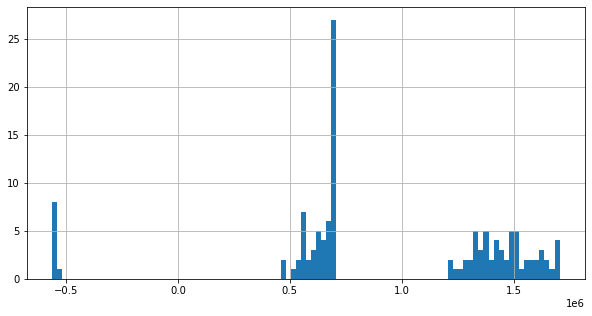

In [124]:
plt.rcParams['figure.figsize'] = (10,5)
pvt['profit'].hist(bins=100)

Видим, что есть выбросы с убытком

In [182]:
pvt['price_per_person'] = pvt['real_revenue_x']/pvt['real_seats_x']

In [186]:
pvt['cost_per_person'] = pvt['cost_of_fly_x']/pvt['real_seats_x']

In [190]:
pvt['profit per minute'] = pvt['profit']/ pvt['flight_duration_minutes']

<AxesSubplot:>

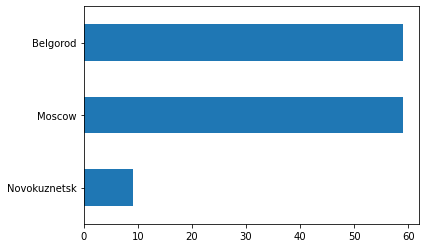

In [121]:
pvt['city_of_arrival'].value_counts(ascending=True).plot(kind='barh')

Добавляем несколько числовых показателей для более точного анализа прибыльности, смотрим в какие города осуществляются рейсы.

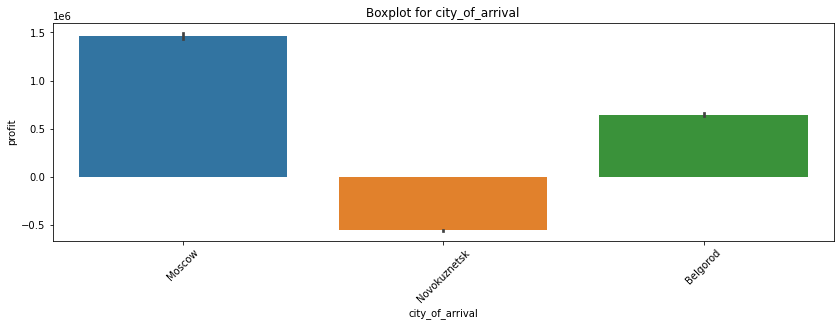

In [175]:
def get_barplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(x=column, y='profit',
                data=pvt.loc[pvt.loc[:, column].isin(
                    pvt.loc[:, column].value_counts().index[:50])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['city_of_arrival']:
    get_barplot(col)

In [209]:
pvt['profit'].mean()

940866.7322834645

In [210]:
pvt.groupby(['city_of_arrival'])['profit'].mean().round()

city_of_arrival
Belgorod         646578.0
Moscow          1462881.0
Novokuznetsk    -552000.0
Name: profit, dtype: float64

Рейсы в Новокузнецк убыточны, узнаем их ID

In [216]:
pvt_todelete = pvt[pvt['city_of_arrival'] == 'Novokuznetsk']
pvt_todelete.flight_id

59    136511
60    136513
61    136514
62    136523
63    136540
64    136544
65    136546
66    136560
67    136567
Name: flight_id, dtype: int64

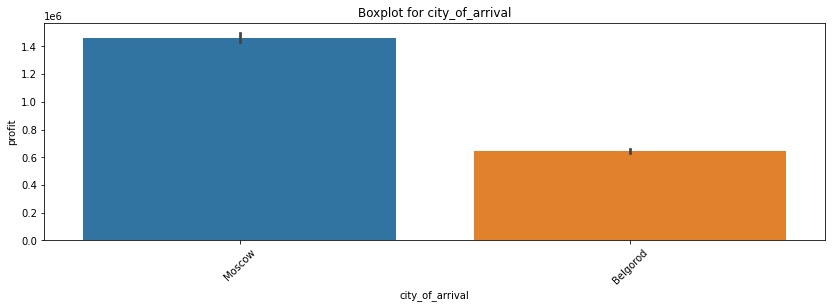

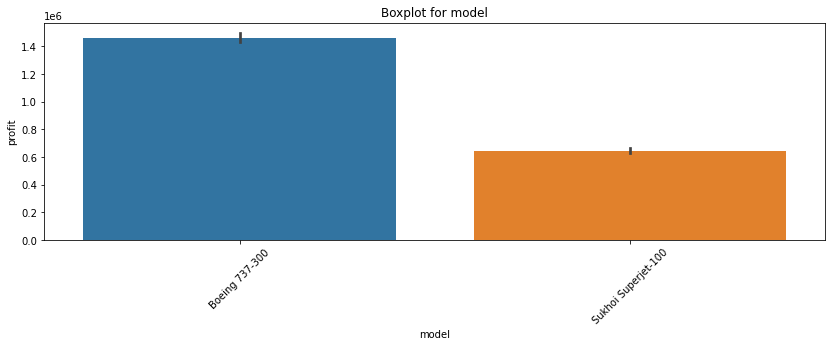

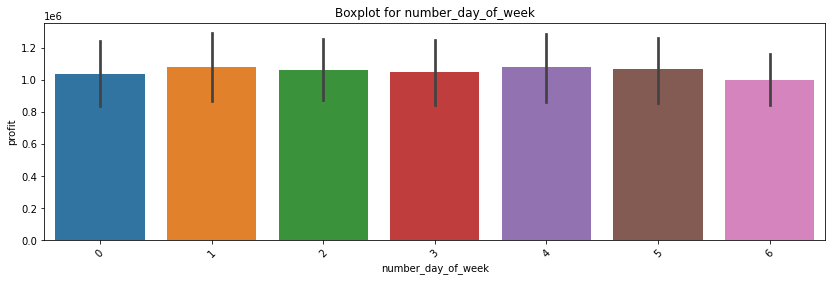

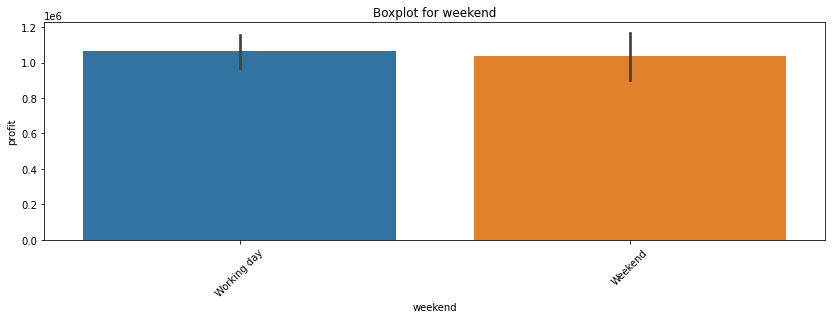

In [192]:
pvt2 = pvt[pvt['city_of_arrival'] != 'Novokuznetsk']
def get_barplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(x=column, y='profit',
                data=pvt2.loc[pvt2.loc[:, column].isin(
                    pvt2.loc[:, column].value_counts().index[:50])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['city_of_arrival','model','number_day_of_week', 'weekend']:
    get_barplot(col)

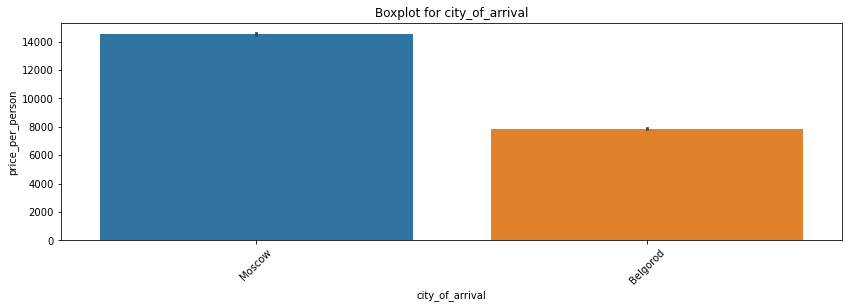

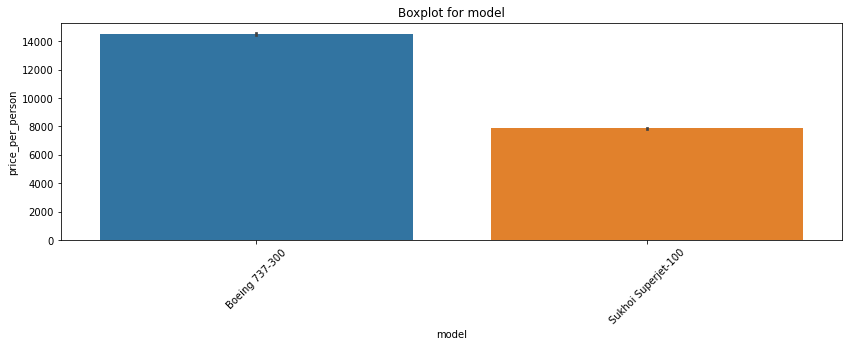

In [184]:
def get_barplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(x=column, y='price_per_person',
                data=pvt2.loc[pvt2.loc[:, column].isin(
                    pvt2.loc[:, column].value_counts().index[:50])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['city_of_arrival','model']:
    get_barplot(col)

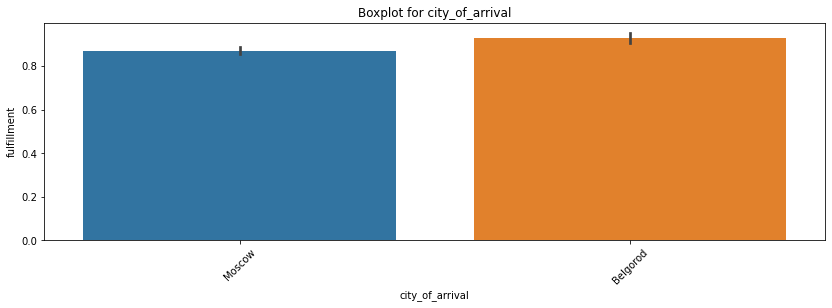

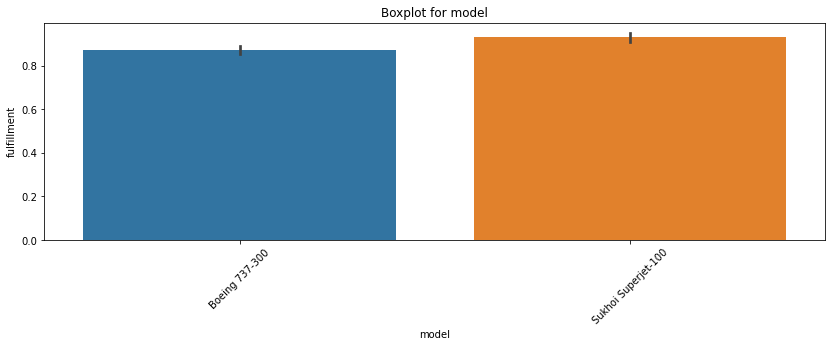

In [185]:
def get_barplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(x=column, y='fulfillment',
                data=pvt2.loc[pvt2.loc[:, column].isin(
                    pvt2.loc[:, column].value_counts().index[:50])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['city_of_arrival','model']:
    get_barplot(col)

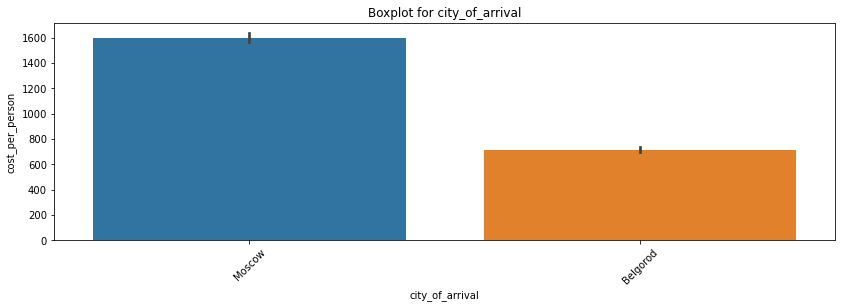

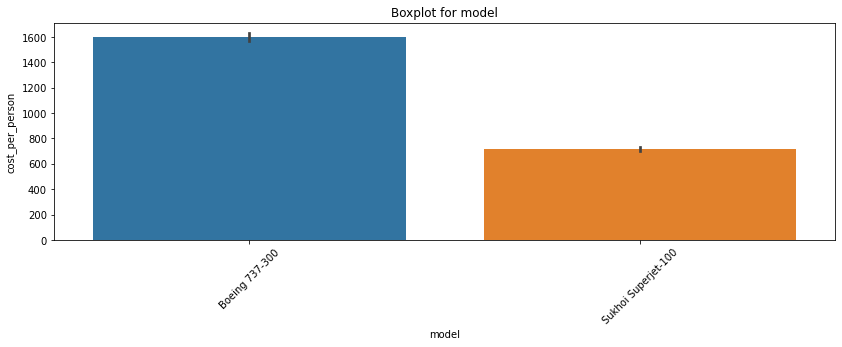

In [189]:

def get_barplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(x=column, y='cost_per_person',
                data=pvt2.loc[pvt2.loc[:, column].isin(
                    pvt2.loc[:, column].value_counts().index[:50])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['city_of_arrival','model']:
    get_barplot(col)

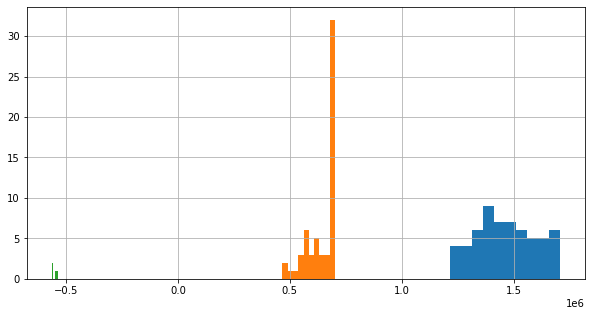

In [126]:
for x in (pvt['city_of_arrival'].value_counts())[0:3].index:
    pvt['profit'][pvt['city_of_arrival'] == x].hist(bins=10)
plt.show()

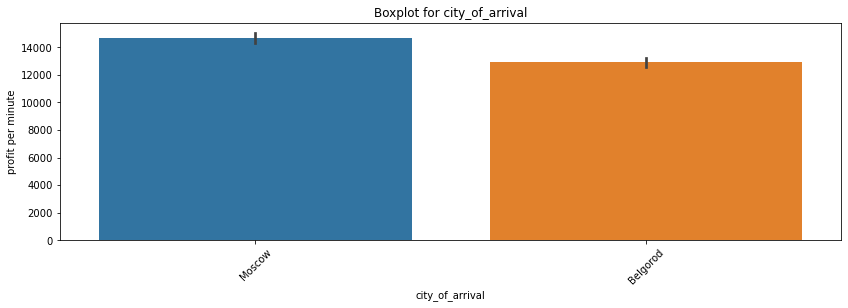

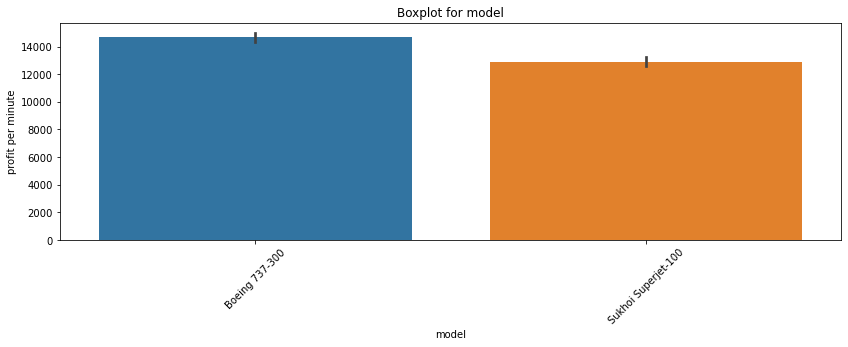

In [193]:
def get_barplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.barplot(x=column, y='profit per minute',
                data=pvt2.loc[pvt2.loc[:, column].isin(
                    pvt2.loc[:, column].value_counts().index[:50])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


for col in ['city_of_arrival','model']:
    get_barplot(col)

<AxesSubplot:>

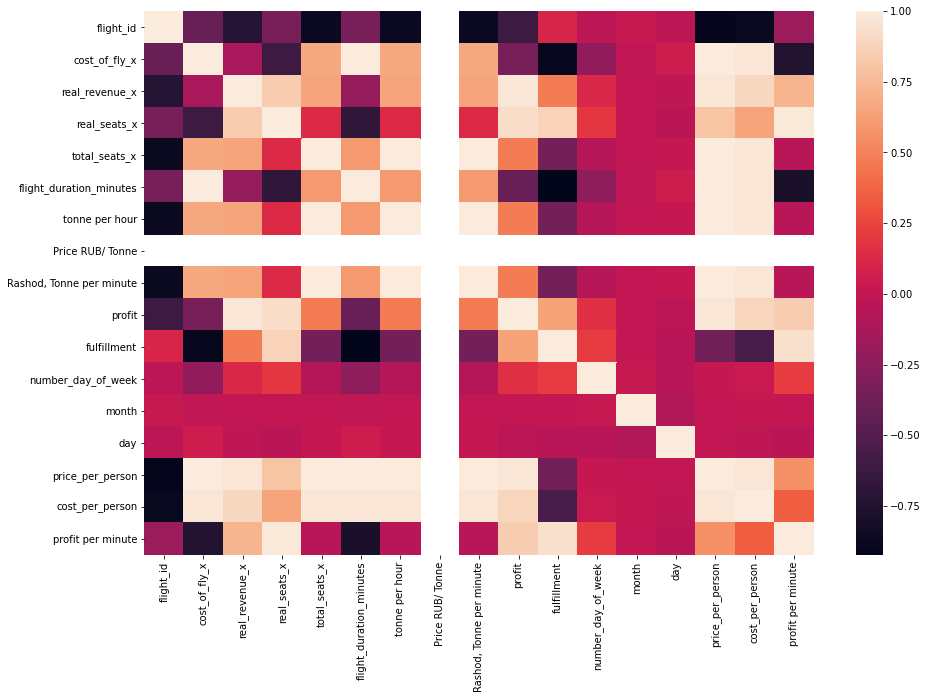

In [194]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(pvt.corr(),)